# <center>  RNN
<center>Zander Bonnet
<center>November 6, 2024



Dataset: Apple Stock Price from 1980-2021 from Kaggle

This dataset is contains stock proce data for apple stock from 1980 into some of 2022. The goal is to use this dataset to create a model that can predict the stock price of apple based on historic data.

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import math
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

/Users/zanderbonnet/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meetnagadia/apple-stock-price-from-19802021")

print("Path to dataset files:", path)

/Users/zanderbonnet/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/zanderbonnet/.cache/kagglehub/datasets/meetnagadia/apple-stock-price-from-19802021/versions/3


In [3]:
#read in CSV
apple = pd.read_csv(path + '/' + os.listdir(path)[0])
apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [4]:
#Format data
apple['Date'] = pd.to_datetime(apple['Date'])
apple.set_index('Date', inplace = True)
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


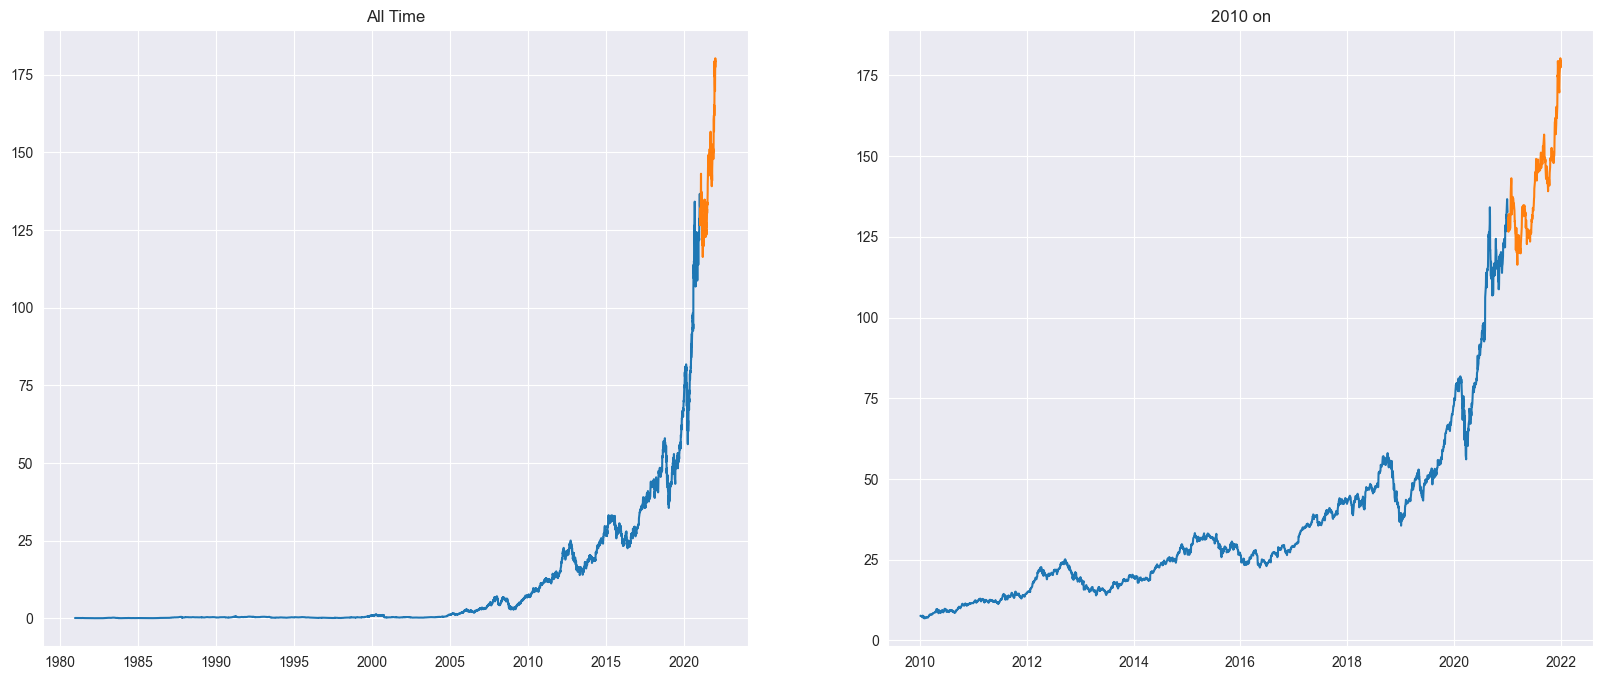

In [5]:
#Visualize the data
fig, ax = plt.subplots(1,2, figsize = (20,8))
ax[0].plot(apple['Close'][:'2020'])
ax[0].plot(apple['Close']['2021':'2021'])
ax[0].set(title = 'All Time')
ax[1].plot(apple['2010':'2020']['Close'])
ax[1].plot(apple['2021':'2021']['Close'])
ax[1].set(title = '2010 on')
plt.show()

These plots show the data from its origin to 2021. In the right plot, we can see the closing stock price from 2010 on. This gives us a closer look at the variation in the data. I chose this time frame because 2010 was the beginning of when the stock price began to fluctuate.

In [6]:
#Get training data. Before 2021
train_data = apple[:'2020']['Close'].values.reshape(-1,1)
print(len(apple[:'2020']))

10100


In [7]:
#Standardize the data
scale = MinMaxScaler(feature_range=(0,1))
train_scale = scale.fit_transform(train_data)

In [8]:
len(train_scale)

10100

In this step I set the window that the model will look back at. In this case the model will look back the previous 60 days inorder to predict the next day.

In [9]:
#Format training data
x_train, y_train = [], []
for i in range(60, len(train_scale)):
  x_train.append(train_scale[i-60:i,0])
  y_train.append(train_scale[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [10]:
print(x_train.shape)
print(y_train.shape)

(10040, 60, 1)
(10040,)


In [11]:
#Create model
mod = Sequential()

#First LSTM
mod.add(LSTM(units= 50, return_sequences = True, input_shape=(x_train.shape[1],1)))
mod.add(Dropout(.2))

#Second LSTM
mod.add(LSTM(units = 50, return_sequences = True))

#Final LSTM
mod.add(LSTM(units = 50))
mod.add(Dropout(.2))

#Final prediction
mod.add(Dense(units = 1))

/Users/zanderbonnet/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
mod.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
mod.compile(optimizer='adam',loss='mean_squared_error', metrics=['mae'])
stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

In [14]:
hist = mod.fit(x_train,y_train, epochs = 75,callbacks=[stop], verbose = 1)

Epoch 1/75
314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0023 - mae: 0.0216
Epoch 2/75
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.5866e-04 - mae: 0.0120
Epoch 3/75
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.6037e-04 - mae: 0.0094
Epoch 4/75
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.7532e-04 - mae: 0.0085
Epoch 5/75
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.3223e-04 - mae: 0.0081
Epoch 6/75
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.8282e-04 - mae: 0.0083
Epoch 7/75
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.4373e-04 - mae: 0.0081
Epoch 8/75
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.4852e-04 - mae: 0.0086
Epoch 9/75
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.5264e-04 - mae: 0.0083
Epoch 10/75
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.2515e-04 - mae: 0.0082
Epoch 11/75
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.5205e-04 - mae: 0.0084
Epoch 12/75
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - 

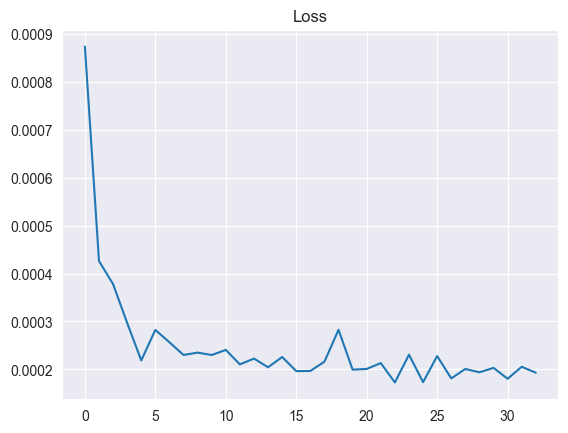

In [15]:
plt.plot(hist.history['loss'])
plt.title('Loss')
plt.show()

The loss function begins to converge at about 33 epochs.

### 2021
Predict 2021

In [16]:
test_data1 = apple['2021':'2021']['Close'].values.reshape(-1,1)
len(test_data1)

252

In [17]:
dataset  = apple['Close'][:'2021']
input = dataset[len(dataset) - len(test_data1) - 60:].values
input = input.reshape(-1,1)
test_scale = scale.transform(input)

In [18]:
x_test = []
for i in range(60, len(test_scale)):
  x_test.append(test_scale[i-60:i,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
print(x_test.shape)

(252, 60, 1)


In [20]:
preds1 = mod.predict(x_test)
preds1 = scale.inverse_transform(preds1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


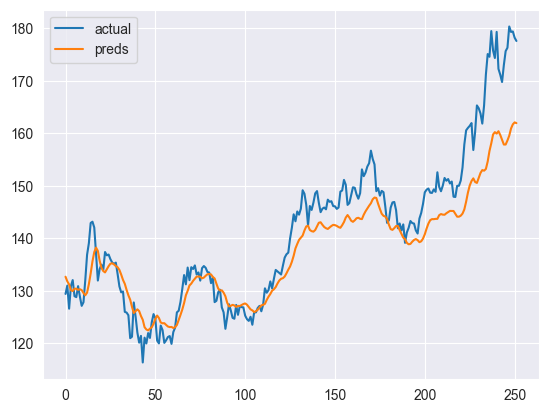

RMSE:  6.530459936572547


In [21]:
plt.plot(test_data1, label = 'actual')
plt.plot(preds1, label = 'preds')
plt.legend()
plt.show()
print('RMSE: ',math.sqrt(mean_squared_error(test_data1,preds1)))

The model performs very well in predicting the closing stock price of Apple in 2021. The RMSE value is about 6.5 so the average error in the prediction is about 6.5 dollars. That is a realativly small error. The model does appear to struggle with the rapid increase in value after day 225.

### 2022
Predict 2022

In [22]:
test_data2 = apple['Close']['2022':'2022'].values.reshape(-1,1)
len(test_data2)

116

In [23]:
dataset  = apple['Close'][:'2022']
input = dataset[len(dataset) - len(test_data2) - 60:].values
input = input.reshape(-1,1)
test_scale = scale.transform(input)

In [24]:
x_test = []
for i in range(60, len(test_scale)):
  x_test.append(test_scale[i-60:i,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [25]:
print(x_test.shape)

(116, 60, 1)


In [26]:
preds2 = mod.predict(x_test)
preds2 = scale.inverse_transform(preds2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


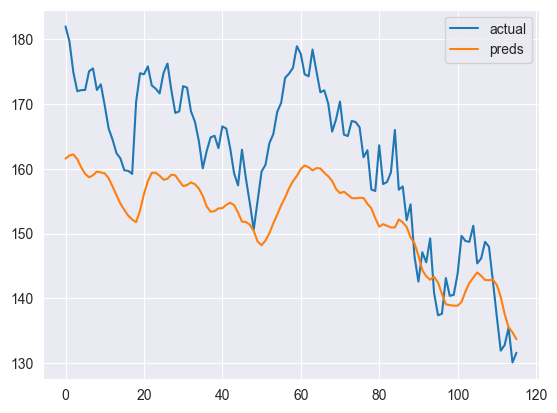

RMSE:  10.972598408457692


In [27]:
plt.plot(test_data2, label = 'actual')
plt.plot(preds2, label = 'preds')
plt.legend()
plt.show()
print('RMSE: ',math.sqrt(mean_squared_error(test_data2,preds2)))

This prediction is also not terrible, but struggles with the extreme changes in price over a short period of time. With a RMSE of 10.9 the error is not very large.

### 2021+2022
Predict 2021 and 2022

In [28]:
test_data3 = apple['Close']['2021':'2022'].values.reshape(-1,1)
len(test_data3)

368

In [29]:
dataset  = apple['Close'][:'2022']
input = dataset[len(dataset) - len(test_data3) - 60:].values
input = input.reshape(-1,1)
test_scale = scale.transform(input)

In [30]:
x_test = []
for i in range(60, len(test_scale)):
  x_test.append(test_scale[i-60:i,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [31]:
print(x_test.shape)

(368, 60, 1)


In [32]:
preds3 = mod.predict(x_test)
preds3 = scale.inverse_transform(preds3)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


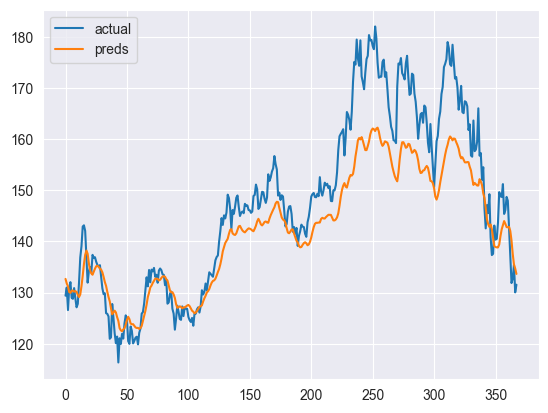

RMSE:  8.194838446497393


In [33]:
plt.plot(test_data3, label = 'actual')
plt.plot(preds3, label = 'preds')
plt.legend()
plt.show()
print('RMSE: ',math.sqrt(mean_squared_error(test_data3,preds3)))

When combining the two previous predictions we can see that the model follows the trends of the stock very well. It shows that it struggles the forecast the extreme peaks that the value achieved, but it follows the overall trend very accurately. With a RMSE of 8.2, the model performs very well on this data.



This model performs fairly well on the given data, but it does struggle with the extreme fluctuations in the data. To improve this model we can adjust a couple of things. We can adjust the number of layers in the model, the number of perceptrons per layer, and the learning rates. 

# Reference

Nagadia, M. (2022, June 21). Apple Stock Price from 1980-2021. Kaggle. https://www.kaggle.com/datasets/meetnagadia/apple-stock-price-from-19802021/data 